In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import sys
sys.path.append('../')
import default_style

In [2]:
TS_DATASET_FOLDER = os.path.join('..', 'dataset')
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, 'preprocessed_traces')
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, 'preproc_ts.df')

TARGET = 'statement'
TRACES = 'syllables_02_STFT'

In [3]:
df = pd.read_csv(DF_PREPROC_FILE).drop(columns=['Unnamed: 0'])
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,end_s,fourier_coeffs,filtered_fourier_coeffs,syll_0_start_index,syll_1_start_index,syll_2_start_index,syll_3_start_index,syll_4_start_index,syll_5_start_index,syll_6_start_index,syll_7_start_index
0,speech,happy,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.061167,2.701833,[5.9604645e-08 9.2448331e-02 7.0120022e-02 ......,[5.9604645e-08 9.2448264e-02 7.0119813e-02 ......,0,1304,2464,3832,4680,5664,6488,9840
1,speech,calm,strong,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.020167,2.983000,[3.3713877e-07 6.0990662e-03 8.3317356e-03 ......,[3.3713877e-07 6.0990625e-03 8.3317189e-03 ......,0,2112,5664,6304,6840,7704,9304,11776
2,speech,fearful,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.057000,2.642500,[4.5448542e-07 2.2871135e-02 2.1308422e-02 ......,[4.5448542e-07 2.2871116e-02 2.1308355e-02 ......,0,2032,3168,4648,5800,6728,7400,9512
3,speech,neutral,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.068500,2.294667,[3.5017729e-07 2.6199006e-02 2.5683409e-02 ......,[3.5017729e-07 2.6198970e-02 2.5683273e-02 ......,0,928,1984,3232,4120,5120,5808,7352
4,speech,calm,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.023667,2.534167,[1.1920929e-07 2.0026919e-03 7.9689088e-04 ......,[1.1920929e-07 2.0026902e-03 7.9688808e-04 ......,0,2104,3672,4808,5928,6944,7600,9056


In [4]:
traces_dict = {}
files = os.listdir(TS_PREPROC_FOLDER)

# SORRY PAOLINO BUT I HAVE A CHICCO PC AND I CANNOT LOAD IT ALL

# for file in files:

#     if file.endswith('.npy'):
#         file_path = os.path.join(TS_PREPROC_FOLDER, file)
#         # dictionary keys are the file names
#         key = os.path.splitext(file)[0]
#         # load array
#         traces_dict[key] = np.load(file_path, allow_pickle=True)

# traces_dict.keys()

file_path = os.path.join(TS_PREPROC_FOLDER, f"{TRACES}.npy")
traces_dict[TRACES] = np.load(file_path, allow_pickle=True)


In [5]:
traces = traces_dict[TRACES]
traces.shape

(2452, 23, 23)

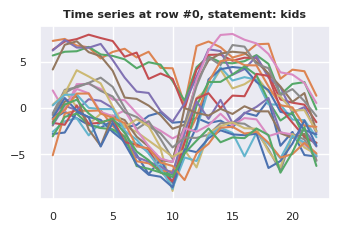

In [6]:
index = 0
statement = df['statement'][index]
plt.plot(traces[index])
plt.title(f'Time series at row #{index}, statement: {statement}')
plt.show()

In [7]:
# sort by actors
sorted_indices = df['actor'].argsort()
df = df.iloc[sorted_indices].reset_index(drop=True)

traces = traces[sorted_indices]

# traces

In [8]:
from sklearn.model_selection import train_test_split

split_index = df[df['actor'] == 'actor_19'].index[0]

X_train = traces[:split_index]
X_test = traces[split_index:]

y_train = df[TARGET][:split_index].to_numpy()
y_test = df[TARGET][split_index:].to_numpy()

X_train_v, X_valid, y_train_v, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=100)

X_train_v.shape, X_valid.shape, X_test.shape, y_train_v.shape, y_valid.shape, y_test.shape

((1462, 23, 23), (366, 23, 23), (624, 23, 23), (1462,), (366,), (624,))

# CNN

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_train_v = label_encoder.transform(y_train_v)
y_valid = label_encoder.transform(y_valid)
y_test = label_encoder.transform(y_test)

y_valid[0]

0

In [10]:
import optuna
from keras.layers import BatchNormalization, Activation
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, GlobalAveragePooling1D
from sklearn.metrics import accuracy_score

def build_and_fit_cnn(X=X_train, y=y_train,
                      n_conv=0, n_hidden=0, hidden_nodes=32,
                      dropout=0.01, filters=8, kernel_size=5, batch_size=16,
                      epochs=32, validation_split=0., verbose=False):

    n_timesteps = X.shape[1]
    n_outputs = len(np.unique(y))
    n_features = X.shape[2]

    model = Sequential()

    model.add(Conv1D(filters=filters,
                     kernel_size=kernel_size,
                     activation='relu',
                     input_shape=(n_timesteps, n_features),
                     name="base_conv"
                     ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    for i in range(n_conv):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Dropout(dropout))

    model.add(GlobalAveragePooling1D())

    for i in range(n_hidden):
        model.add(Dense(hidden_nodes, activation='relu'))

    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_split=validation_split)

    return model

2023-06-26 13:02:38.676059: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-26 13:02:38.760466: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-26 13:02:38.762233: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 13:02:40.357346: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
# Test to check the accuracy of a "belly" network
test_model = build_and_fit_cnn(n_conv=2, n_hidden=3, hidden_nodes=256, epochs=8, verbose=True)

Epoch 1/8
115/115 [==============================] - 5s 7ms/step - loss: 0.4842 - accuracy: 0.7659
Epoch 2/8
115/115 [==============================] - 1s 8ms/step - loss: 0.2378 - accuracy: 0.9081
Epoch 3/8
115/115 [==============================] - 1s 8ms/step - loss: 0.1819 - accuracy: 0.9316
Epoch 4/8
115/115 [==============================] - 1s 8ms/step - loss: 0.1454 - accuracy: 0.9475
Epoch 5/8
115/115 [==============================] - 1s 10ms/step - loss: 0.1236 - accuracy: 0.9562
Epoch 6/8
115/115 [==============================] - 1s 11ms/step - loss: 0.1125 - accuracy: 0.9551
Epoch 7/8
115/115 [==============================] - 1s 8ms/step - loss: 0.0948 - accuracy: 0.9655
Epoch 8/8
115/115 [==============================] - 1s 7ms/step - loss: 0.0908 - accuracy: 0.9710


In [12]:
# objective function to be minimized
def objective_fun(trial):

    n_conv = trial.suggest_int('n_conv', 0, 3)
    n_hidden = trial.suggest_int('n_hidden', 0, 3)
    hidden_nodes = trial.suggest_int('hidden_nodes', 8, 256)
    dropout = trial.suggest_float('dropout', 0, 1)
    filters = trial.suggest_int('filters', 2, 16)
    kernel_size = trial.suggest_int('kernel_size', 2, 16)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    epochs = trial.suggest_int('epochs', 5, 90)
    
    print(f"Running little bitch having n_conv={n_conv}, dropout={dropout}, hidden_nodes={hidden_nodes}")
    
    cnn = build_and_fit_cnn(X=X_train_v,
                            y=y_train_v,
                            n_hidden=n_hidden,
                            hidden_nodes=hidden_nodes,
                            n_conv=n_conv,
                            dropout=dropout,
                            filters=filters,
                            kernel_size=kernel_size,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=False
                           )

    y_pred = np.argmax(cnn.predict(X_valid), axis=1)

    error = accuracy_score(y_valid, y_pred)

    return error


study = optuna.create_study(direction='maximize')
study.optimize(objective_fun, n_trials=150, n_jobs=-1, catch=ValueError)

[I 2023-06-26 13:02:54,871] A new study created in memory with name: no-name-3308537d-492b-489a-b6c1-ca3c153a2b50


Running little bitch having n_conv=3, dropout=0.6777308541204436, hidden_nodes=244
Running little bitch having n_conv=0, dropout=0.7196261746574508, hidden_nodes=65
Running little bitch having n_conv=0, dropout=0.8262229236107901, hidden_nodes=30
Running little bitch having n_conv=0, dropout=0.28464217181316875, hidden_nodes=212


[W 2023-06-26 13:02:55,477] Trial 0 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 244, 'dropout': 0.6777308541204436, 'filters': 7, 'kernel_size': 12, 'batch_size': 55, 'epochs': 81} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/home

Running little bitch having n_conv=1, dropout=0.02526260121223156, hidden_nodes=141


[W 2023-06-26 13:02:55,823] Trial 4 failed with parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 141, 'dropout': 0.02526260121223156, 'filters': 3, 'kernel_size': 15, 'batch_size': 60, 'epochs': 36} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 3] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/hom

Running little bitch having n_conv=1, dropout=0.5026840403992158, hidden_nodes=130
12/12 [==============================] - 1s 15ms/step


[I 2023-06-26 13:03:18,605] Trial 1 finished with value: 0.9836065573770492 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 65, 'dropout': 0.7196261746574508, 'filters': 6, 'kernel_size': 12, 'batch_size': 22, 'epochs': 17}. Best is trial 1 with value: 0.9836065573770492.


Running little bitch having n_conv=0, dropout=0.03895960138289145, hidden_nodes=128
12/12 [==============================] - 1s 12ms/step


[I 2023-06-26 13:03:31,277] Trial 3 finished with value: 0.9562841530054644 and parameters: {'n_conv': 0, 'n_hidden': 3, 'hidden_nodes': 212, 'dropout': 0.28464217181316875, 'filters': 15, 'kernel_size': 16, 'batch_size': 43, 'epochs': 56}. Best is trial 1 with value: 0.9836065573770492.


Running little bitch having n_conv=2, dropout=0.8315454375943376, hidden_nodes=52


[W 2023-06-26 13:03:31,546] Trial 7 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 52, 'dropout': 0.8315454375943376, 'filters': 5, 'kernel_size': 16, 'batch_size': 58, 'epochs': 41} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 5] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/home/

Running little bitch having n_conv=1, dropout=0.8909211468914999, hidden_nodes=137


[W 2023-06-26 13:03:31,787] Trial 8 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 137, 'dropout': 0.8909211468914999, 'filters': 7, 'kernel_size': 13, 'batch_size': 22, 'epochs': 63} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 11, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/hom

Running little bitch having n_conv=1, dropout=0.18657737506664185, hidden_nodes=170


[W 2023-06-26 13:03:32,094] Trial 9 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 170, 'dropout': 0.18657737506664185, 'filters': 9, 'kernel_size': 13, 'batch_size': 55, 'epochs': 45} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 11, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=3, dropout=0.6139122332589948, hidden_nodes=57
12/12 [==============================] - 0s 6ms/step


[I 2023-06-26 13:03:37,735] Trial 6 finished with value: 0.9617486338797814 and parameters: {'n_conv': 0, 'n_hidden': 3, 'hidden_nodes': 128, 'dropout': 0.03895960138289145, 'filters': 5, 'kernel_size': 12, 'batch_size': 54, 'epochs': 26}. Best is trial 1 with value: 0.9836065573770492.


Running little bitch having n_conv=3, dropout=0.9939326676281257, hidden_nodes=193


[W 2023-06-26 13:03:38,078] Trial 11 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 193, 'dropout': 0.9939326676281257, 'filters': 7, 'kernel_size': 12, 'batch_size': 63, 'epochs': 19} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/hom

Running little bitch having n_conv=1, dropout=0.3437490685450034, hidden_nodes=69
12/12 [==============================] - 1s 6ms/step


[I 2023-06-26 13:03:43,304] Trial 5 finished with value: 0.9672131147540983 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 130, 'dropout': 0.5026840403992158, 'filters': 6, 'kernel_size': 6, 'batch_size': 36, 'epochs': 85}. Best is trial 1 with value: 0.9836065573770492.


Running little bitch having n_conv=1, dropout=0.789625402799694, hidden_nodes=152
12/12 [==============================] - 1s 5ms/step


[I 2023-06-26 13:03:48,258] Trial 2 finished with value: 0.9781420765027322 and parameters: {'n_conv': 0, 'n_hidden': 3, 'hidden_nodes': 30, 'dropout': 0.8262229236107901, 'filters': 3, 'kernel_size': 15, 'batch_size': 36, 'epochs': 66}. Best is trial 1 with value: 0.9836065573770492.


Running little bitch having n_conv=2, dropout=0.18057921765225426, hidden_nodes=185


[W 2023-06-26 13:03:48,552] Trial 14 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 185, 'dropout': 0.18057921765225426, 'filters': 8, 'kernel_size': 16, 'batch_size': 31, 'epochs': 13} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 8] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.7733303891773246, hidden_nodes=162


[W 2023-06-26 13:03:48,862] Trial 15 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 162, 'dropout': 0.7733303891773246, 'filters': 16, 'kernel_size': 13, 'batch_size': 40, 'epochs': 44} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 11, 16] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=0, dropout=0.752200505285764, hidden_nodes=248
12/12 [==============================] - 1s 10ms/step


[I 2023-06-26 13:03:59,910] Trial 10 finished with value: 0.9207650273224044 and parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 57, 'dropout': 0.6139122332589948, 'filters': 7, 'kernel_size': 4, 'batch_size': 62, 'epochs': 24}. Best is trial 1 with value: 0.9836065573770492.


Running little bitch having n_conv=1, dropout=0.45317057896810975, hidden_nodes=175


[I 2023-06-26 13:04:00,051] Trial 12 finished with value: 0.9726775956284153 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 69, 'dropout': 0.3437490685450034, 'filters': 6, 'kernel_size': 6, 'batch_size': 41, 'epochs': 29}. Best is trial 1 with value: 0.9836065573770492.


Running little bitch having n_conv=1, dropout=0.1698432404760306, hidden_nodes=73


[W 2023-06-26 13:04:00,331] Trial 18 failed with parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 73, 'dropout': 0.1698432404760306, 'filters': 14, 'kernel_size': 15, 'batch_size': 30, 'epochs': 18} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 14] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=3, dropout=0.8429364788840755, hidden_nodes=234
12/12 [==============================] - 0s 6ms/step


[I 2023-06-26 13:04:22,449] Trial 17 finished with value: 0.9016393442622951 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 175, 'dropout': 0.45317057896810975, 'filters': 3, 'kernel_size': 3, 'batch_size': 55, 'epochs': 31}. Best is trial 1 with value: 0.9836065573770492.


Running little bitch having n_conv=2, dropout=0.10845745156615938, hidden_nodes=14
12/12 [==============================] - 1s 9ms/step


[I 2023-06-26 13:04:35,558] Trial 13 finished with value: 0.9781420765027322 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 152, 'dropout': 0.789625402799694, 'filters': 6, 'kernel_size': 6, 'batch_size': 39, 'epochs': 60}. Best is trial 1 with value: 0.9836065573770492.


Running little bitch having n_conv=3, dropout=0.646859298330417, hidden_nodes=124
12/12 [==============================] - 1s 17ms/step


[I 2023-06-26 13:04:46,518] Trial 16 finished with value: 0.9890710382513661 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 248, 'dropout': 0.752200505285764, 'filters': 8, 'kernel_size': 14, 'batch_size': 19, 'epochs': 75}. Best is trial 16 with value: 0.9890710382513661.


Running little bitch having n_conv=3, dropout=0.9808399770803508, hidden_nodes=256


[W 2023-06-26 13:04:47,677] Trial 22 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 256, 'dropout': 0.9808399770803508, 'filters': 11, 'kernel_size': 11, 'batch_size': 16, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9998112185146255, hidden_nodes=255


[W 2023-06-26 13:04:48,935] Trial 23 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 255, 'dropout': 0.9998112185146255, 'filters': 11, 'kernel_size': 11, 'batch_size': 16, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9264339110903295, hidden_nodes=249


[W 2023-06-26 13:04:51,114] Trial 24 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 249, 'dropout': 0.9264339110903295, 'filters': 11, 'kernel_size': 11, 'batch_size': 18, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.946636263595733, hidden_nodes=256


[W 2023-06-26 13:04:52,345] Trial 25 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 256, 'dropout': 0.946636263595733, 'filters': 11, 'kernel_size': 11, 'batch_size': 16, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=3, dropout=0.9736808146466526, hidden_nodes=253


[W 2023-06-26 13:04:53,083] Trial 26 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 253, 'dropout': 0.9736808146466526, 'filters': 11, 'kernel_size': 11, 'batch_size': 16, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9135041532348396, hidden_nodes=250


[W 2023-06-26 13:04:53,653] Trial 27 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 250, 'dropout': 0.9135041532348396, 'filters': 11, 'kernel_size': 11, 'batch_size': 16, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9184418171970219, hidden_nodes=255


[W 2023-06-26 13:04:54,296] Trial 28 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 255, 'dropout': 0.9184418171970219, 'filters': 11, 'kernel_size': 11, 'batch_size': 18, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9557768186232769, hidden_nodes=248


[W 2023-06-26 13:04:54,958] Trial 29 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 248, 'dropout': 0.9557768186232769, 'filters': 11, 'kernel_size': 11, 'batch_size': 18, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9722499259028441, hidden_nodes=254


[W 2023-06-26 13:04:55,535] Trial 30 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 254, 'dropout': 0.9722499259028441, 'filters': 12, 'kernel_size': 11, 'batch_size': 19, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9975521241544834, hidden_nodes=251


[W 2023-06-26 13:04:56,203] Trial 31 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 251, 'dropout': 0.9975521241544834, 'filters': 11, 'kernel_size': 11, 'batch_size': 18, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9748283980202062, hidden_nodes=250


[W 2023-06-26 13:04:57,079] Trial 32 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 250, 'dropout': 0.9748283980202062, 'filters': 11, 'kernel_size': 11, 'batch_size': 16, 'epochs': 87} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9986651628185375, hidden_nodes=253


[W 2023-06-26 13:04:57,906] Trial 33 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 253, 'dropout': 0.9986651628185375, 'filters': 11, 'kernel_size': 11, 'batch_size': 17, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9905225383826803, hidden_nodes=244


[W 2023-06-26 13:04:58,641] Trial 34 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 244, 'dropout': 0.9905225383826803, 'filters': 11, 'kernel_size': 11, 'batch_size': 16, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9672452630581965, hidden_nodes=256


[W 2023-06-26 13:04:59,347] Trial 35 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 256, 'dropout': 0.9672452630581965, 'filters': 10, 'kernel_size': 11, 'batch_size': 16, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 10] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9080283200886025, hidden_nodes=255


[W 2023-06-26 13:04:59,920] Trial 36 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 255, 'dropout': 0.9080283200886025, 'filters': 11, 'kernel_size': 11, 'batch_size': 17, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9751473709130488, hidden_nodes=256


[W 2023-06-26 13:05:00,520] Trial 37 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 256, 'dropout': 0.9751473709130488, 'filters': 11, 'kernel_size': 11, 'batch_size': 18, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9997855850446548, hidden_nodes=256


[W 2023-06-26 13:05:01,189] Trial 38 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 256, 'dropout': 0.9997855850446548, 'filters': 11, 'kernel_size': 11, 'batch_size': 19, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9629302683235793, hidden_nodes=254


[W 2023-06-26 13:05:01,770] Trial 39 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 254, 'dropout': 0.9629302683235793, 'filters': 11, 'kernel_size': 11, 'batch_size': 18, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9972437133520716, hidden_nodes=223


[W 2023-06-26 13:05:02,417] Trial 40 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 223, 'dropout': 0.9972437133520716, 'filters': 11, 'kernel_size': 11, 'batch_size': 16, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9987009021162769, hidden_nodes=251


[W 2023-06-26 13:05:03,002] Trial 41 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 251, 'dropout': 0.9987009021162769, 'filters': 13, 'kernel_size': 11, 'batch_size': 16, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9768665733183997, hidden_nodes=249


[W 2023-06-26 13:05:03,675] Trial 42 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 249, 'dropout': 0.9768665733183997, 'filters': 11, 'kernel_size': 11, 'batch_size': 16, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9739677886674871, hidden_nodes=241


[W 2023-06-26 13:05:04,353] Trial 43 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 241, 'dropout': 0.9739677886674871, 'filters': 11, 'kernel_size': 11, 'batch_size': 17, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.8760261974957564, hidden_nodes=247


[W 2023-06-26 13:05:05,063] Trial 44 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 247, 'dropout': 0.8760261974957564, 'filters': 11, 'kernel_size': 12, 'batch_size': 17, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9366362585490161, hidden_nodes=239


[W 2023-06-26 13:05:05,673] Trial 45 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 239, 'dropout': 0.9366362585490161, 'filters': 11, 'kernel_size': 11, 'batch_size': 16, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9801776849349659, hidden_nodes=256


[W 2023-06-26 13:05:06,158] Trial 46 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 256, 'dropout': 0.9801776849349659, 'filters': 11, 'kernel_size': 11, 'batch_size': 16, 'epochs': 82} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.8533859032965441, hidden_nodes=252


[W 2023-06-26 13:05:06,827] Trial 47 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 252, 'dropout': 0.8533859032965441, 'filters': 12, 'kernel_size': 11, 'batch_size': 17, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9403227604228759, hidden_nodes=239


[W 2023-06-26 13:05:07,410] Trial 48 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 239, 'dropout': 0.9403227604228759, 'filters': 11, 'kernel_size': 11, 'batch_size': 16, 'epochs': 85} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9916291845060251, hidden_nodes=247


[W 2023-06-26 13:05:07,988] Trial 49 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 247, 'dropout': 0.9916291845060251, 'filters': 13, 'kernel_size': 11, 'batch_size': 17, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9848011238114667, hidden_nodes=256


[W 2023-06-26 13:05:08,625] Trial 50 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 256, 'dropout': 0.9848011238114667, 'filters': 12, 'kernel_size': 11, 'batch_size': 17, 'epochs': 87} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9314922807598239, hidden_nodes=233


[W 2023-06-26 13:05:09,233] Trial 51 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 233, 'dropout': 0.9314922807598239, 'filters': 11, 'kernel_size': 11, 'batch_size': 17, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.8501159169026276, hidden_nodes=246


[W 2023-06-26 13:05:09,793] Trial 52 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 246, 'dropout': 0.8501159169026276, 'filters': 11, 'kernel_size': 11, 'batch_size': 16, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9993262593819391, hidden_nodes=249


[W 2023-06-26 13:05:10,304] Trial 53 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 249, 'dropout': 0.9993262593819391, 'filters': 11, 'kernel_size': 11, 'batch_size': 16, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9863018147441859, hidden_nodes=249


[W 2023-06-26 13:05:10,837] Trial 54 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 249, 'dropout': 0.9863018147441859, 'filters': 11, 'kernel_size': 11, 'batch_size': 18, 'epochs': 86} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=2, dropout=0.9927532827240333, hidden_nodes=226


[W 2023-06-26 13:05:11,416] Trial 55 failed with parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 226, 'dropout': 0.9927532827240333, 'filters': 11, 'kernel_size': 11, 'batch_size': 22, 'epochs': 84} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9928605246659941, hidden_nodes=249


[W 2023-06-26 13:05:11,976] Trial 56 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 249, 'dropout': 0.9928605246659941, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 84} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9626853901088168, hidden_nodes=249


[W 2023-06-26 13:05:12,538] Trial 57 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 249, 'dropout': 0.9626853901088168, 'filters': 11, 'kernel_size': 11, 'batch_size': 19, 'epochs': 87} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9966121081649276, hidden_nodes=227


[W 2023-06-26 13:05:13,040] Trial 58 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 227, 'dropout': 0.9966121081649276, 'filters': 11, 'kernel_size': 11, 'batch_size': 18, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9981623940164626, hidden_nodes=254


[W 2023-06-26 13:05:13,606] Trial 59 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 254, 'dropout': 0.9981623940164626, 'filters': 11, 'kernel_size': 11, 'batch_size': 19, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9928965426278417, hidden_nodes=251


[W 2023-06-26 13:05:14,174] Trial 60 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 251, 'dropout': 0.9928965426278417, 'filters': 12, 'kernel_size': 11, 'batch_size': 19, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9613169523632067, hidden_nodes=253


[W 2023-06-26 13:05:14,798] Trial 61 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 253, 'dropout': 0.9613169523632067, 'filters': 11, 'kernel_size': 11, 'batch_size': 16, 'epochs': 84} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9404309384120013, hidden_nodes=250


[W 2023-06-26 13:05:15,360] Trial 62 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 250, 'dropout': 0.9404309384120013, 'filters': 11, 'kernel_size': 11, 'batch_size': 19, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9959817802820118, hidden_nodes=251


[W 2023-06-26 13:05:15,912] Trial 63 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 251, 'dropout': 0.9959817802820118, 'filters': 11, 'kernel_size': 11, 'batch_size': 16, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9265202150811059, hidden_nodes=246


[W 2023-06-26 13:05:16,533] Trial 64 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 246, 'dropout': 0.9265202150811059, 'filters': 11, 'kernel_size': 11, 'batch_size': 19, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.990093503696309, hidden_nodes=256


[W 2023-06-26 13:05:17,074] Trial 65 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 256, 'dropout': 0.990093503696309, 'filters': 11, 'kernel_size': 11, 'batch_size': 19, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=3, dropout=0.990648825505316, hidden_nodes=251


[W 2023-06-26 13:05:17,642] Trial 66 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 251, 'dropout': 0.990648825505316, 'filters': 11, 'kernel_size': 11, 'batch_size': 16, 'epochs': 85} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=3, dropout=0.9707365232928704, hidden_nodes=246


[W 2023-06-26 13:05:18,305] Trial 67 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 246, 'dropout': 0.9707365232928704, 'filters': 12, 'kernel_size': 11, 'batch_size': 16, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.983312340629353, hidden_nodes=243


[W 2023-06-26 13:05:18,858] Trial 68 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 243, 'dropout': 0.983312340629353, 'filters': 11, 'kernel_size': 11, 'batch_size': 16, 'epochs': 89} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=3, dropout=0.9998891880077815, hidden_nodes=243


[W 2023-06-26 13:05:19,378] Trial 69 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 243, 'dropout': 0.9998891880077815, 'filters': 11, 'kernel_size': 11, 'batch_size': 17, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9042855919105114, hidden_nodes=252
12/12 [==============================] - 1s 10ms/step


[W 2023-06-26 13:05:19,892] Trial 70 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 252, 'dropout': 0.9042855919105114, 'filters': 11, 'kernel_size': 11, 'batch_size': 16, 'epochs': 88} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.9557788214898781, hidden_nodes=248
Running little bitch having n_conv=2, dropout=0.9877209632157226, hidden_nodes=80


[W 2023-06-26 13:05:20,620] Trial 72 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 80, 'dropout': 0.9877209632157226, 'filters': 11, 'kernel_size': 12, 'batch_size': 17, 'epochs': 8} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/hom

Running little bitch having n_conv=2, dropout=0.9656238529544316, hidden_nodes=90
Running little bitch having n_conv=2, dropout=0.9680393848906325, hidden_nodes=97


[W 2023-06-26 13:05:21,292] Trial 74 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 90, 'dropout': 0.9656238529544316, 'filters': 11, 'kernel_size': 12, 'batch_size': 19, 'epochs': 6} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/hom

Running little bitch having n_conv=2, dropout=0.6901923531461686, hidden_nodes=91
Running little bitch having n_conv=2, dropout=0.9821913792011787, hidden_nodes=89


[W 2023-06-26 13:05:21,945] Trial 75 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 91, 'dropout': 0.6901923531461686, 'filters': 11, 'kernel_size': 12, 'batch_size': 18, 'epochs': 7} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/hom

Running little bitch having n_conv=2, dropout=0.9237094957597509, hidden_nodes=251
Running little bitch having n_conv=2, dropout=0.9809266178426272, hidden_nodes=93


[W 2023-06-26 13:05:22,622] Trial 77 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 251, 'dropout': 0.9237094957597509, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 8} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.9308573525219861, hidden_nodes=93
Running little bitch having n_conv=2, dropout=0.952199803469717, hidden_nodes=71


[W 2023-06-26 13:05:23,340] Trial 79 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 93, 'dropout': 0.9308573525219861, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 5} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/hom

Running little bitch having n_conv=2, dropout=0.9978592512099446, hidden_nodes=91
Running little bitch having n_conv=2, dropout=0.6849086379625031, hidden_nodes=91


[W 2023-06-26 13:05:24,082] Trial 81 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 91, 'dropout': 0.9978592512099446, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.9435545038409492, hidden_nodes=94
Running little bitch having n_conv=2, dropout=0.9691013829460541, hidden_nodes=91


[W 2023-06-26 13:05:24,707] Trial 83 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 94, 'dropout': 0.9435545038409492, 'filters': 12, 'kernel_size': 12, 'batch_size': 18, 'epochs': 9} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/hom

Running little bitch having n_conv=2, dropout=0.6812172334389245, hidden_nodes=92
Running little bitch having n_conv=2, dropout=0.9744882267446285, hidden_nodes=93


[W 2023-06-26 13:05:25,239] Trial 85 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 92, 'dropout': 0.6812172334389245, 'filters': 12, 'kernel_size': 12, 'batch_size': 16, 'epochs': 6} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/hom

Running little bitch having n_conv=2, dropout=0.9941333712930669, hidden_nodes=91
Running little bitch having n_conv=2, dropout=0.9921838470209043, hidden_nodes=91


[W 2023-06-26 13:05:25,773] Trial 87 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 91, 'dropout': 0.9941333712930669, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 6} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/hom

Running little bitch having n_conv=2, dropout=0.9988833238510018, hidden_nodes=78
Running little bitch having n_conv=2, dropout=0.9636323438407954, hidden_nodes=94


[W 2023-06-26 13:05:26,313] Trial 89 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 78, 'dropout': 0.9988833238510018, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 9} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/hom

Running little bitch having n_conv=2, dropout=0.9213785336190174, hidden_nodes=92
Running little bitch having n_conv=2, dropout=0.9244275674413353, hidden_nodes=88


[W 2023-06-26 13:05:26,834] Trial 91 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 92, 'dropout': 0.9213785336190174, 'filters': 11, 'kernel_size': 12, 'batch_size': 17, 'epochs': 6} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/hom

Running little bitch having n_conv=2, dropout=0.998040372839612, hidden_nodes=91
Running little bitch having n_conv=2, dropout=0.9895402737590298, hidden_nodes=93


[W 2023-06-26 13:05:27,382] Trial 93 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 91, 'dropout': 0.998040372839612, 'filters': 11, 'kernel_size': 12, 'batch_size': 18, 'epochs': 80} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/hom

Running little bitch having n_conv=2, dropout=0.9638541799030491, hidden_nodes=98
Running little bitch having n_conv=2, dropout=0.9793717348674532, hidden_nodes=93


[W 2023-06-26 13:05:27,933] Trial 96 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 93, 'dropout': 0.9793717348674532, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 12} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.989387017756372, hidden_nodes=100
Running little bitch having n_conv=2, dropout=0.9601941548981634, hidden_nodes=98


[W 2023-06-26 13:05:28,423] Trial 97 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 100, 'dropout': 0.989387017756372, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.9827657877241167, hidden_nodes=92
Running little bitch having n_conv=2, dropout=0.9972058069623502, hidden_nodes=88


[W 2023-06-26 13:05:28,937] Trial 99 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 92, 'dropout': 0.9827657877241167, 'filters': 12, 'kernel_size': 12, 'batch_size': 16, 'epochs': 5} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/hom

Running little bitch having n_conv=2, dropout=0.9928935535859387, hidden_nodes=105
Running little bitch having n_conv=2, dropout=0.9559265194995001, hidden_nodes=91


[W 2023-06-26 13:05:29,467] Trial 101 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 105, 'dropout': 0.9928935535859387, 'filters': 10, 'kernel_size': 12, 'batch_size': 16, 'epochs': 7} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 10] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=2, dropout=0.9245575011359946, hidden_nodes=89
Running little bitch having n_conv=2, dropout=0.9534992223981511, hidden_nodes=93


[W 2023-06-26 13:05:29,977] Trial 103 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 89, 'dropout': 0.9245575011359946, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 6} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.9486339565720071, hidden_nodes=104
Running little bitch having n_conv=2, dropout=0.9719806709358088, hidden_nodes=95


[W 2023-06-26 13:05:30,474] Trial 105 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 104, 'dropout': 0.9486339565720071, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 6} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=2, dropout=0.9713356995424174, hidden_nodes=91


[W 2023-06-26 13:05:31,017] Trial 107 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 91, 'dropout': 0.9713356995424174, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 6} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.6739565018742972, hidden_nodes=89


[W 2023-06-26 13:05:31,265] Trial 108 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 89, 'dropout': 0.6739565018742972, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 5} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.9977294097251616, hidden_nodes=91


[W 2023-06-26 13:05:31,564] Trial 109 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 91, 'dropout': 0.9977294097251616, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 8} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.9643059105876102, hidden_nodes=89


[W 2023-06-26 13:05:31,805] Trial 110 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 89, 'dropout': 0.9643059105876102, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 8} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.979970455677744, hidden_nodes=100


[W 2023-06-26 13:05:32,110] Trial 111 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 100, 'dropout': 0.979970455677744, 'filters': 11, 'kernel_size': 12, 'batch_size': 17, 'epochs': 5} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.9630062690597032, hidden_nodes=88


[W 2023-06-26 13:05:32,320] Trial 112 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 88, 'dropout': 0.9630062690597032, 'filters': 11, 'kernel_size': 12, 'batch_size': 17, 'epochs': 6} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.936240944789543, hidden_nodes=96
Running little bitch having n_conv=2, dropout=0.9717365788048326, hidden_nodes=92


[W 2023-06-26 13:05:32,670] Trial 113 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 96, 'dropout': 0.936240944789543, 'filters': 11, 'kernel_size': 12, 'batch_size': 17, 'epochs': 9} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/hom

Running little bitch having n_conv=2, dropout=0.9201115444684629, hidden_nodes=94


[W 2023-06-26 13:05:33,196] Trial 115 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 94, 'dropout': 0.9201115444684629, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 5} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.9940926414480179, hidden_nodes=92
Running little bitch having n_conv=2, dropout=0.9947682363208716, hidden_nodes=93


[W 2023-06-26 13:05:33,514] Trial 116 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 92, 'dropout': 0.9940926414480179, 'filters': 11, 'kernel_size': 12, 'batch_size': 17, 'epochs': 9} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.9805414325575659, hidden_nodes=79
Running little bitch having n_conv=2, dropout=0.7005628682733699, hidden_nodes=86


[W 2023-06-26 13:05:34,085] Trial 118 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 79, 'dropout': 0.9805414325575659, 'filters': 12, 'kernel_size': 12, 'batch_size': 18, 'epochs': 11} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=2, dropout=0.9787808905670284, hidden_nodes=87
Running little bitch having n_conv=2, dropout=0.985822947963851, hidden_nodes=90


[W 2023-06-26 13:05:34,641] Trial 120 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 87, 'dropout': 0.9787808905670284, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 6} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.9924069203324797, hidden_nodes=89
Running little bitch having n_conv=2, dropout=0.9396333671398163, hidden_nodes=94


[W 2023-06-26 13:05:35,190] Trial 122 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 89, 'dropout': 0.9924069203324797, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 9} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.9815187265062149, hidden_nodes=88
Running little bitch having n_conv=2, dropout=0.9995144170584701, hidden_nodes=94


[W 2023-06-26 13:05:35,727] Trial 124 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 88, 'dropout': 0.9815187265062149, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 10} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=2, dropout=0.9546752022947882, hidden_nodes=91
Running little bitch having n_conv=2, dropout=0.9932423482209292, hidden_nodes=95


[W 2023-06-26 13:05:36,274] Trial 127 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 95, 'dropout': 0.9932423482209292, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 7} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.9620171552124221, hidden_nodes=88
Running little bitch having n_conv=2, dropout=0.9943510338233774, hidden_nodes=90


[W 2023-06-26 13:05:36,817] Trial 129 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 90, 'dropout': 0.9943510338233774, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 8} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.9850034538170667, hidden_nodes=88
Running little bitch having n_conv=2, dropout=0.9842465572358963, hidden_nodes=93


[W 2023-06-26 13:05:37,514] Trial 131 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 93, 'dropout': 0.9842465572358963, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 86} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=2, dropout=0.991696647065198, hidden_nodes=92
Running little bitch having n_conv=2, dropout=0.9982061524730151, hidden_nodes=80
 1/12 [=>............................] - ETA: 12s

[W 2023-06-26 13:05:38,148] Trial 132 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 92, 'dropout': 0.991696647065198, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 5} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/hom

 8/12 [===================>..........] - ETA: 0s 

[W 2023-06-26 13:05:38,185] Trial 133 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 80, 'dropout': 0.9982061524730151, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 6} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

12/12 [==============================] - 1s 23ms/step
Running little bitch having n_conv=2, dropout=0.9906161281843573, hidden_nodes=91
12/12 [==============================] - 1s 8ms/step


[W 2023-06-26 13:05:38,719] Trial 135 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 91, 'dropout': 0.9906161281843573, 'filters': 11, 'kernel_size': 12, 'batch_size': 17, 'epochs': 7} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.9220593271651681, hidden_nodes=90
Running little bitch having n_conv=0, dropout=0.940445817654923, hidden_nodes=85


[I 2023-06-26 13:05:39,065] Trial 21 finished with value: 0.9098360655737705 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 124, 'dropout': 0.646859298330417, 'filters': 11, 'kernel_size': 6, 'batch_size': 17, 'epochs': 27}. Best is trial 16 with value: 0.9890710382513661.


Running little bitch having n_conv=0, dropout=0.9690648285311831, hidden_nodes=91
Running little bitch having n_conv=0, dropout=0.9877135267239981, hidden_nodes=83


[W 2023-06-26 13:05:39,631] Trial 136 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 90, 'dropout': 0.9220593271651681, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 90} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 11] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=0, dropout=0.9308796808170554, hidden_nodes=89
12/12 [==============================] - 0s 7ms/step


[I 2023-06-26 13:05:51,466] Trial 139 finished with value: 0.9754098360655737 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 83, 'dropout': 0.9877135267239981, 'filters': 10, 'kernel_size': 12, 'batch_size': 16, 'epochs': 5}. Best is trial 16 with value: 0.9890710382513661.


Running little bitch having n_conv=2, dropout=0.693435736363669, hidden_nodes=255
 1/12 [=>............................] - ETA: 4s

[W 2023-06-26 13:05:51,987] Trial 141 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 255, 'dropout': 0.693435736363669, 'filters': 12, 'kernel_size': 12, 'batch_size': 24, 'epochs': 5} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

12/12 [==============================] - 1s 16ms/step


[I 2023-06-26 13:05:52,282] Trial 137 finished with value: 0.9781420765027322 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 85, 'dropout': 0.940445817654923, 'filters': 11, 'kernel_size': 12, 'batch_size': 17, 'epochs': 7}. Best is trial 16 with value: 0.9890710382513661.


Running little bitch having n_conv=2, dropout=0.7364132794401232, hidden_nodes=250


[W 2023-06-26 13:05:52,627] Trial 142 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 191, 'dropout': 0.6955388385575803, 'filters': 12, 'kernel_size': 12, 'batch_size': 24, 'epochs': 44} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=2, dropout=0.6953782577194803, hidden_nodes=245


[W 2023-06-26 13:05:52,956] Trial 143 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 250, 'dropout': 0.7364132794401232, 'filters': 9, 'kernel_size': 10, 'batch_size': 26, 'epochs': 43} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.6762883392516071, hidden_nodes=256
Running little bitch having n_conv=2, dropout=0.7065584336536137, hidden_nodes=253


[W 2023-06-26 13:05:53,598] Trial 145 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 256, 'dropout': 0.6762883392516071, 'filters': 13, 'kernel_size': 10, 'batch_size': 26, 'epochs': 75} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=2, dropout=0.7245653332595181, hidden_nodes=245
Running little bitch having n_conv=2, dropout=0.6946749444543517, hidden_nodes=248


[W 2023-06-26 13:05:53,997] Trial 147 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 245, 'dropout': 0.7245653332595181, 'filters': 13, 'kernel_size': 14, 'batch_size': 26, 'epochs': 43} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 10, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "

Running little bitch having n_conv=2, dropout=0.7112412657122165, hidden_nodes=195


[W 2023-06-26 13:05:54,402] Trial 148 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 248, 'dropout': 0.6946749444543517, 'filters': 13, 'kernel_size': 10, 'batch_size': 25, 'epochs': 42} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_25375/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_25375/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

12/12 [==============================] - 0s 3ms/step


[I 2023-06-26 13:05:54,747] Trial 140 finished with value: 0.9672131147540983 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 89, 'dropout': 0.9308796808170554, 'filters': 10, 'kernel_size': 12, 'batch_size': 16, 'epochs': 5}. Best is trial 16 with value: 0.9890710382513661.


12/12 [==============================] - 0s 2ms/step


[I 2023-06-26 13:05:55,615] Trial 138 finished with value: 0.9562841530054644 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 91, 'dropout': 0.9690648285311831, 'filters': 11, 'kernel_size': 12, 'batch_size': 16, 'epochs': 12}. Best is trial 16 with value: 0.9890710382513661.


In [13]:
best_params = study.best_params
best_params

{'n_conv': 0,
 'n_hidden': 1,
 'hidden_nodes': 248,
 'dropout': 0.752200505285764,
 'filters': 8,
 'kernel_size': 14,
 'batch_size': 19,
 'epochs': 75}

In [14]:
cnn = build_and_fit_cnn(**best_params)
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 10, 8)             2584      
                                                                 
 batch_normalization_3 (Batc  (None, 10, 8)            32        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 10, 8)             0         
                                                                 
 global_average_pooling1d_1   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 248)               2232      
                                                                 
 dense_5 (Dense)             (None, 2)                

In [15]:
from sklearn.metrics import f1_score, classification_report, cohen_kappa_score

y_pred = np.argmax(cnn.predict(X_test), axis=1)

print(f'Cohen k {cohen_kappa_score(y_test, y_pred)}')
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 2ms/step
Cohen k 0.9551282051282052
Accuracy 0.9775641025641025
F1-score [0.97727273 0.9778481 ]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       312
           1       0.97      0.99      0.98       312

    accuracy                           0.98       624
   macro avg       0.98      0.98      0.98       624
weighted avg       0.98      0.98      0.98       624

